In [1]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

## Video segmentation and tracking with SAM 3

This notebook demonstrates how to use SAM 3 for interactive video segmentation and dense tracking. It covers the following capabilities:

- **Text prompts**: Using natural language descriptions to segment objects (e.g., "person", "shoe")
- **Point prompts**: Adding positive/negative clicks to segment and refine objects

We use the terms _segment_ or _mask_ to refer to the model prediction for an object on a single frame, and _masklet_ to refer to the spatio-temporal masks across the entire video. 

# <a target="_blank" href="https://colab.research.google.com/github/facebookresearch/sam3/blob/main/notebooks/sam3_video_predictor_example.ipynb">
#   <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
# </a>

In [2]:
!nvidia-smi

Fri Nov 21 18:32:17 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.95.05              Driver Version: 580.95.05      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      On  |   00000000:31:00.0 Off |                    0 |
| N/A   43C    P0             18W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Set-up

In this example, we allow running inference either on a single GPU or multiple GPUs.

In [3]:
import os
import sam3
import torch

sam3_root = os.path.join(os.path.dirname(sam3.__file__), "..")

# use all available GPUs on the machine
gpus_to_use = range(torch.cuda.device_count())
# # use only a single GPU
# gpus_to_use = [torch.cuda.current_device()]

/home/reite/Reite/testspace/sam3/venv/lib/python3.12/site-packages/torch/backends/__init__.py:46: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  self.setter(val)


In [4]:
from sam3.model_builder import build_sam3_video_predictor

predictor = build_sam3_video_predictor(gpus_to_use=gpus_to_use)

INFO 2025-11-21 18:32:20,130 236736 sam3_video_predictor.py: 299: using the following GPU IDs: [0]
INFO 2025-11-21 18:32:20,234 236736 sam3_video_predictor.py: 315: 


	*** START loading model on all ranks ***


INFO 2025-11-21 18:32:20,235 236736 sam3_video_predictor.py: 317: loading model on rank=0 with world_size=1 -- this could take a while ...
INFO 2025-11-21 18:32:26,726 236736 sam3_video_base.py: 124: setting max_num_objects=10000 and num_obj_for_compile=16
INFO 2025-11-21 18:32:29,521 236736 sam3_video_predictor.py: 319: loading model on rank=0 with world_size=1 -- DONE locally
INFO 2025-11-21 18:32:29,522 236736 sam3_video_predictor.py: 330: 


	*** DONE loading model on all ranks ***




#### Inference and visualization utils

In [5]:
import glob
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from sam3.visualization_utils import (
    load_frame,
    prepare_masks_for_visualization,
    visualize_formatted_frame_output,
    save_masklet_video
)

# font size for axes titles
plt.rcParams["axes.titlesize"] = 12
plt.rcParams["figure.titlesize"] = 12


def propagate_in_video(predictor, session_id):
    # we will just propagate from frame 0 to the end of the video
    outputs_per_frame = {}
    for response in predictor.handle_stream_request(
        request=dict(
            type="propagate_in_video",
            session_id=session_id,
        )
    ):
        outputs_per_frame[response["frame_index"]] = response["outputs"]

    return outputs_per_frame


def abs_to_rel_coords(coords, IMG_WIDTH, IMG_HEIGHT, coord_type="point"):
    """Convert absolute coordinates to relative coordinates (0-1 range)

    Args:
        coords: List of coordinates
        coord_type: 'point' for [x, y] or 'box' for [x, y, w, h]
    """
    if coord_type == "point":
        return [[x / IMG_WIDTH, y / IMG_HEIGHT] for x, y in coords]
    elif coord_type == "box":
        return [
            [x / IMG_WIDTH, y / IMG_HEIGHT, w / IMG_WIDTH, h / IMG_HEIGHT]
            for x, y, w, h in coords
        ]
    else:
        raise ValueError(f"Unknown coord_type: {coord_type}")

### Loading an example video

We assume that the video is stored as either **a list of JPEG frames with filenames like `<frame_index>.jpg`** or **an MP4 video**.

Note that you can extract their JPEG frames using ffmpeg (https://ffmpeg.org/) as follows:
```
ffmpeg -i <your_video>.mp4 -q:v 2 -start_number 0 <output_dir>/'%05d.jpg'
```
where `-q:v` generates high-quality JPEG frames and `-start_number 0` asks ffmpeg to start the JPEG file from `00000.jpg`.

In [6]:
# "video_path" needs to be either a JPEG folder or a MP4 video file
#video_path = "/data/engine_reite_results/vCai6dwL1CzXj0bpF1U7/ext_top/frames"#f"{sam3_root}/assets/videos/0001"
video_id = "vCai6dwL1CzXj0bpF1U7"
video_path = f"/data/engine_reite_results/{video_id}/ext_top/frames"

In [7]:
# load "video_frames_for_vis" for visualization purposes (they are not used by the model)
if isinstance(video_path, str) and video_path.endswith(".mp4"):
    cap = cv2.VideoCapture(video_path)
    video_frames_for_vis = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        video_frames_for_vis.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    cap.release()
else:
    video_frames_for_vis = glob.glob(os.path.join(video_path, "*.jpg"))
    try:
        # integer sort instead of string sort (so that e.g. "2.jpg" is before "11.jpg")
        video_frames_for_vis.sort(
            key=lambda p: int(os.path.splitext(os.path.basename(p))[0])
        )
    except ValueError:
        # fallback to lexicographic sort if the format is not "<frame_index>.jpg"
        print(
            f'frame names are not in "<frame_index>.jpg" format: {video_frames_for_vis[:5]=}, '
            f"falling back to lexicographic sort."
        )
        video_frames_for_vis.sort()

### Opening an inference session on this video

SAM 3 requires stateful inference for interactive video segmentation, so we need to initialize an **inference session** on this video.

During initialization, it loads all the video frames and stores their pixels in the session state.

In [8]:
response = predictor.handle_request(
    request=dict(
        type="start_session",
        resource_path=video_path,
    )
)
session_id = response["session_id"]

frame loading (image folder) [rank=0]: 100%|██████████| 483/483 [00:06<00:00, 75.50it/s]


### Video promptable concept segmentation with text

Using SAM 3 you can describe objects using natural language, and the model will automatically detect and track all instances of that object throughout the video.

In the example below, we add a text prompt on frame 0 and propagation throughout the video. Here we use the text prompt "person" to detect all people in the video. SAM 3 will automatically identify multiple person instances and assign each a unique object ID.

Note that the first call might be slower due to setting up buffers. **You can rerun all the cells below when measuring speed.**

In [9]:
# note: in case you already ran one text prompt and now want to switch to another text prompt
# it's required to reset the session first (otherwise the results would be wrong)
_ = predictor.handle_request(
    request=dict(
        type="reset_session",
        session_id=session_id,
    )
)

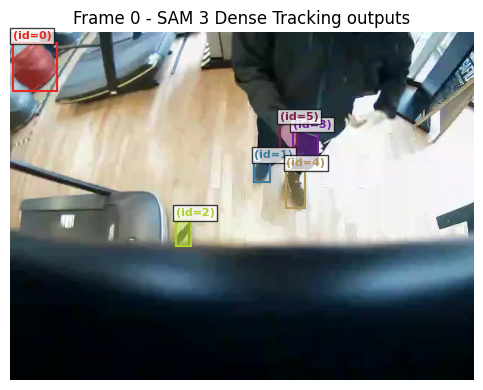

In [10]:
prompt_text_str = "small object"
frame_idx = 0  # add a text prompt on frame 0
response = predictor.handle_request(
    request=dict(
        type="add_prompt",
        session_id=session_id,
        frame_index=frame_idx,
        text=prompt_text_str,
    )
)
out = response["outputs"]

plt.close("all")
visualize_formatted_frame_output(
    frame_idx,
    video_frames_for_vis,
    outputs_list=[prepare_masks_for_visualization({frame_idx: out})],
    titles=["SAM 3 Dense Tracking outputs"],
    figsize=(6, 4),
)

In [11]:
# now we propagate the outputs from frame 0 to the end of the video and collect all outputs
import time
start = time.time()
outputs_per_frame = propagate_in_video(predictor, session_id)
print("Inference time: ", round(time.time()-start, 2), "s")

# finally, we reformat the outputs for visualization and plot the outputs every 60 frames
#outputs_per_frame = prepare_masks_for_visualization(outputs_per_frame)

# vis_frame_stride = 60
# plt.close("all")
# for frame_idx in range(0, len(outputs_per_frame), vis_frame_stride):
#     visualize_formatted_frame_output(
#         frame_idx,
#         video_frames_for_vis,
#         outputs_list=[outputs_per_frame],
#         titles=["SAM 3 Dense Tracking outputs"],
#         figsize=(6, 4),
#     )

propagate_in_video:   0%|          | 0/483 [00:00<?, ?it/s]

propagate_in_video: 0it [00:00, ?it/s]

In [ ]:
save_root = video_path.replace("frames", "vis")
os.makedirs(save_root, exist_ok=True)
file_name = f"{prompt_text_str}_v1.mp4"
save_masklet_video(video_frames=video_frames_for_vis, outputs=outputs_per_frame, out_path=os.path.join(save_root, file_name), fps=30)

100%|██████████| 483/483 [00:01<00:00, 283.76it/s]
ffmpeg version 7.0.2-static https://johnvansickle.com/ffmpeg/  Copyright (c) 2000-2024 the FFmpeg developers
  built with gcc 8 (Debian 8.3.0-6)
  configuration: --enable-gpl --enable-version3 --enable-static --disable-debug --disable-ffplay --disable-indev=sndio --disable-outdev=sndio --cc=gcc --enable-fontconfig --enable-frei0r --enable-gnutls --enable-gmp --enable-libgme --enable-gray --enable-libaom --enable-libfribidi --enable-libass --enable-libvmaf --enable-libfreetype --enable-libmp3lame --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-librubberband --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libvorbis --enable-libopus --enable-libtheora --enable-libvidstab --enable-libvo-amrwbenc --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libdav1d --enable-libxvid --enable-libzvbi --enable-libzimg
  libavutil      59.  8.100 / 59.  8.100
  liba

Re-encoded video saved to /data/engine_reite_results/vCai6dwL1CzXj0bpF1U7/ext_top/vis/test_3.mp4


[out#0/mp4 @ 0x362c1a40] video:2279KiB audio:0KiB subtitle:0KiB other streams:0KiB global headers:0KiB muxing overhead: 0.233108%
frame=  483 fps=322 q=-1.0 Lsize=    2284KiB time=00:00:16.03 bitrate=1166.9kbits/s speed=10.7x    
[libx264 @ 0x362bc580] frame I:3     Avg QP:21.51  size: 20830
[libx264 @ 0x362bc580] frame P:287   Avg QP:23.70  size:  6773
[libx264 @ 0x362bc580] frame B:193   Avg QP:26.74  size:  1691
[libx264 @ 0x362bc580] consecutive B-frames: 37.5% 22.8% 14.9% 24.8%
[libx264 @ 0x362bc580] mb I  I16..4: 18.6% 71.5%  9.9%
[libx264 @ 0x362bc580] mb P  I16..4:  1.9%  8.9%  0.7%  P16..4: 42.6% 11.1%  7.4%  0.0%  0.0%    skip:27.5%
[libx264 @ 0x362bc580] mb B  I16..4:  0.7%  2.8%  0.1%  B16..8: 30.5%  3.2%  0.9%  direct: 2.7%  skip:59.2%  L0:46.0% L1:45.2% BI: 8.8%
[libx264 @ 0x362bc580] 8x8 transform intra:77.3% inter:80.3%
[libx264 @ 0x362bc580] coded y,uvDC,uvAC intra: 47.6% 64.3% 13.9% inter: 18.3% 22.7% 1.6%
[libx264 @ 0x362bc580] i16 v,h,dc,p: 21% 38% 18% 23%
[libx264 

100%|██████████| 483/483 [00:03<00:00, 124.77it/s]
ffmpeg version 7.0.2-static https://johnvansickle.com/ffmpeg/  Copyright (c) 2000-2024 the FFmpeg developers
  built with gcc 8 (Debian 8.3.0-6)
  configuration: --enable-gpl --enable-version3 --enable-static --disable-debug --disable-ffplay --disable-indev=sndio --disable-outdev=sndio --cc=gcc --enable-fontconfig --enable-frei0r --enable-gnutls --enable-gmp --enable-libgme --enable-gray --enable-libaom --enable-libfribidi --enable-libass --enable-libvmaf --enable-libfreetype --enable-libmp3lame --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-librubberband --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libvorbis --enable-libopus --enable-libtheora --enable-libvidstab --enable-libvo-amrwbenc --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libdav1d --enable-libxvid --enable-libzvbi --enable-libzimg
  libavutil      59.  8.100 / 59.  8.100
  liba

Re-encoded video saved to /data/engine_reite_results/vCai6dwL1CzXj0bpF1U7/ext_top/vis/small object_v1.mp4


[out#0/mp4 @ 0xf9438c0] video:2361KiB audio:0KiB subtitle:0KiB other streams:0KiB global headers:0KiB muxing overhead: 0.257046%
frame=  483 fps=218 q=-1.0 Lsize=    2367KiB time=00:00:16.03 bitrate=1209.5kbits/s speed=7.25x    
[libx264 @ 0xf944500] frame I:3     Avg QP:21.62  size: 22988
[libx264 @ 0xf944500] frame P:193   Avg QP:23.74  size:  8915
[libx264 @ 0xf944500] frame B:287   Avg QP:27.52  size:  2187
[libx264 @ 0xf944500] consecutive B-frames: 15.1% 12.8% 12.4% 59.6%
[libx264 @ 0xf944500] mb I  I16..4: 18.5% 67.0% 14.5%
[libx264 @ 0xf944500] mb P  I16..4:  2.4% 12.5%  1.4%  P16..4: 40.4% 13.1%  9.2%  0.0%  0.0%    skip:20.9%
[libx264 @ 0xf944500] mb B  I16..4:  0.6%  2.3%  0.2%  B16..8: 32.3%  4.8%  1.5%  direct: 2.6%  skip:55.7%  L0:46.3% L1:45.3% BI: 8.3%
[libx264 @ 0xf944500] 8x8 transform intra:75.1% inter:75.6%
[libx264 @ 0xf944500] coded y,uvDC,uvAC intra: 49.4% 66.1% 18.2% inter: 16.0% 21.9% 3.9%
[libx264 @ 0xf944500] i16 v,h,dc,p: 19% 39% 18% 25%
[libx264 @ 0xf944500